# Starbucks Offers Analysis



# Project Overview
Promotional offers are a pivotal part of customer engagement; whether it entices them to redeem a great deal or simply keep the brand in a customer's mind. The goal of this project is to analyze how certain variables affect sales using the Starbucks data from the [Starbucks Capstone Challenge](https://www.kaggle.com/datasets/ruhaniroy/starbucks-capstone-challenge/data). We aim to focus on behavioral insights rather than predictions to inform marketing strategy or offer different designs.

## Data Dictionary
// insert table to show definitions

## Stategy
1. Importing necessary settings
2. Loading Data
3. Data Preprocessing
4. Merging to a unified Datasets
5. Exploratory Data Analysis


## 1) Imports + settings

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)


## 2) Load data

Update `DATA_DIR` to the folder where your CSVs live.

In [2]:
portfolio = pd.read_csv('../data/portfolio.csv')
profile   = pd.read_csv('../data/profile.csv')
transcript= pd.read_csv('../data/transcript.csv')

## 3) Data Preprocessing

In [3]:
print(portfolio.shape, profile.shape, transcript.shape)

(10, 9) (17000, 5) (59980, 7)


In [4]:
portfolio.head()
profile.head()
transcript.head()

portfolio.isna().sum()
profile.isna().sum()
transcript.isna().sum()

person                0
event                 0
value/offer id    21099
time                  0
value/amount      43057
value/offer_id    55804
value/reward      55804
dtype: int64

Offer ID appears in 2 different keys, `value/offer_id` and `value/offer id`, so we have to merge them together to not lose data

In [5]:
transcript['offer_id'] = transcript['value/offer_id'].combine_first(transcript['value/offer id'])
transcript = transcript.drop(columns=['value/offer_id', 'value/offer id'])

For readability and for the future process, we will begin renaming columns in our for convenience sake and consistency.

In [6]:
transcript.rename(columns={'person': 'customer_id', 'value/amount': 'transaction_amount', 'value/reward': 'promo_reward'}, inplace = True)
profile.rename(columns={'id': 'customer_id'}, inplace = True)
portfolio.rename(columns={'id': 'offer_id'}, inplace = True)



118 seems to be the default value when someone has not entered an age, skewing the data.

In [7]:
display(profile[['age']].value_counts()[:3])

profile['age'] = profile['age'].replace(118, np.nan)

age
118    2175
58      408
53      372
Name: count, dtype: int64

Standardizing and filling `null` values

In [8]:
transcript['event'] = transcript['event'].astype(str).str.strip().str.lower()

# income may be using 0 as its null value but not guaranteed
#profile['income'] = profile['income'].replace(0, np.nan)

profile['gender'] = profile['gender'].fillna('Unknown')

transcript['time'] = pd.to_numeric(transcript['time'], errors='coerce')


Expand channels using one-hot

Creating a centralized `channels` instead of `channels/1`, `channels/2`, and `channels/3`

In [9]:
if 'channels' in portfolio.columns:
    channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).groupby(level=0).sum()
    portfolio = pd.concat([portfolio.drop(columns=['channels']), channel_dummies], axis=1)
else:
    channel_cols = [c for c in portfolio.columns if c.startswith('channels/')]
    if channel_cols:
        unique_channels = pd.unique(portfolio[channel_cols].values.ravel())
        unique_channels = [c for c in unique_channels if pd.notna(c)]
        for ch in unique_channels:
            portfolio[ch] = portfolio[channel_cols].eq(ch).any(axis=1).astype(int)
        portfolio = portfolio.drop(columns=channel_cols)


## 4) Build a unified events table

In [10]:
df = transcript.merge(portfolio, on='offer_id', how='left')
df = df.merge(profile, on='customer_id', how='left')


# deduplicating
offer_mask = df['event'].isin(['offer received','offer viewed','offer completed'])
df_offer = df[offer_mask].drop_duplicates(subset=['customer_id','event','offer_id','time'])


df_tx = df[df['event']=='transaction'].drop_duplicates(subset=['customer_id','event','time','transaction_amount'])

df = pd.concat([df_offer, df_tx], ignore_index=True)
df.shape


(39983, 18)

Constructing an offers table (received → viewed → completed)

For each **offer receipt**, we attach the **first view** and **first completion** that happen **after receipt** and **within the offer's active window** (`duration` days).

In [11]:
# Keep only offer-related events
offer_df = df[df['event'].isin(['offer received','offer viewed','offer completed'])].copy()

received = offer_df[offer_df['event'] == 'offer received'].copy()
viewed   = offer_df[offer_df['event'] == 'offer viewed'][['customer_id','offer_id','time']].copy()
completed= offer_df[offer_df['event'] == 'offer completed'][['customer_id','offer_id','time']].copy()

received = received.rename(columns={'time':'recv_time'})
viewed   = viewed.rename(columns={'time':'view_time'})
completed= completed.rename(columns={'time':'comp_time'})

# De-dup receipts (some datasets have duplicates)
received = received.drop_duplicates(subset=['customer_id','offer_id','recv_time'])

def match_first_after(received_grp, events_grp, recv_col, event_col, duration_col='duration'):
    """For each receipt time, pick the first event time >= receipt time, if it occurs within the offer window."""
    ev_times = np.sort(events_grp[event_col].dropna().values)
    r = received_grp[recv_col].values
    end = r + received_grp[duration_col].values * 24
    out = np.full(len(r), np.nan)

    for i, t in enumerate(r):
        j = np.searchsorted(ev_times, t, side='left')
        if j < len(ev_times) and ev_times[j] <= end[i]:
            out[i] = ev_times[j]
    return out

rows = []
for (cid, oid), grp in received.groupby(['customer_id','offer_id']):
    grp = grp.sort_values('recv_time').copy()
    vgrp = viewed[(viewed.customer_id==cid) & (viewed.offer_id==oid)]
    cgrp = completed[(completed.customer_id==cid) & (completed.offer_id==oid)]

    grp['view_time'] = match_first_after(grp, vgrp, 'recv_time', 'view_time')
    grp['comp_time'] = match_first_after(grp, cgrp, 'recv_time', 'comp_time')
    rows.append(grp)

offers = pd.concat(rows, ignore_index=True)

offers['was_viewed'] = offers['view_time'].notna()
offers['was_completed'] = offers['comp_time'].notna()
offers['time_to_view'] = offers['view_time'] - offers['recv_time']
offers['time_to_complete'] = offers['comp_time'] - offers['recv_time']

offers[['customer_id','offer_id','offer_type','recv_time','was_viewed','was_completed']].head()


,customer_id,offer_id,offer_type,recv_time,was_viewed,was_completed
0,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,informational,0,True,False
1,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,discount,0,True,True
2,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,informational,0,True,False
3,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,informational,0,True,False
4,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,bogo,0,True,False


Computing to create a `spend_in_window` variable to find the gross amount.
This creates `spend_in_window`, used later in the boxplots later.

In [12]:
tx = df[df['event']=='transaction'][['customer_id','time','transaction_amount']].copy()
tx = tx.dropna(subset=['time']).sort_values(['customer_id','time'])

offers = offers.dropna(subset=['recv_time']).sort_values(['customer_id','recv_time']).copy()
offers['end_time'] = offers['recv_time'] + offers['duration'] * 24

# Efficient per-customer window-sum using cumulative sums + searchsorted
offers['spend_in_window'] = 0.0


# function to find the spending amount for customers
for cid, off_grp in offers.groupby('customer_id', sort=False):
    t = tx[tx['customer_id']==cid]
    if t.empty:
        continue

    times = t['time'].to_numpy()
    amounts = t['transaction_amount'].fillna(0).to_numpy()
    csum = np.concatenate([[0.0], np.cumsum(amounts)])

    start_idx = np.searchsorted(times, off_grp['recv_time'].to_numpy(), side='left')
    end_idx   = np.searchsorted(times, off_grp['end_time'].to_numpy(), side='right')

    spend = csum[end_idx] - csum[start_idx]
    offers.loc[off_grp.index, 'spend_in_window'] = spend

offers[['offer_type','was_completed','spend_in_window']].head()


,offer_type,was_completed,spend_in_window
0,informational,False,0.00
1,discount,True,74.02
2,informational,False,2.51
3,informational,False,25.92
4,bogo,False,0.00


## 5) Visualizations

Discount and BOGO offers were sent in roughly similar volumes, while informational offers were sent less frequently.

Offer distribution is relatively balanced between discount and BOGO promotions, suggesting comparable prioritization by Starbucks, while informational offers are deployed less often.

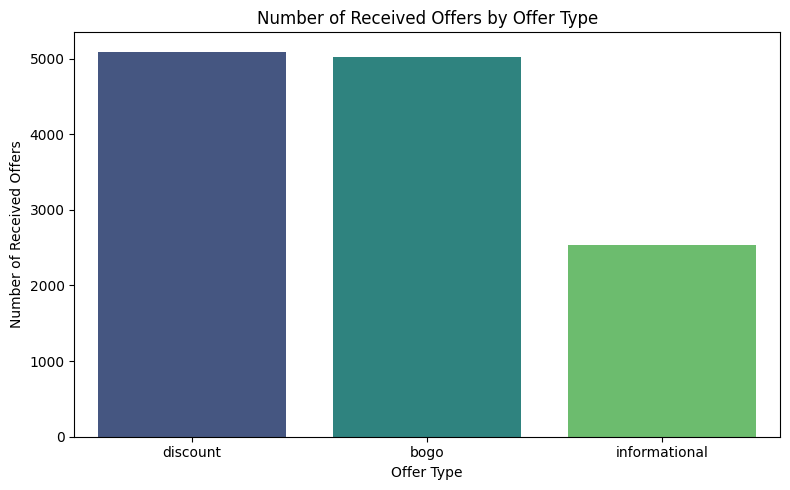

In [13]:
funnel = (offers
          .groupby('offer_type')
          .agg(received=('offer_id','size'),
               view_rate=('was_viewed','mean'),
               complete_rate=('was_completed','mean'),
               complete_given_view=('was_completed', lambda s: s.loc[offers.loc[s.index,'was_viewed']].mean()))
          .sort_values('received', ascending=False))



plt.figure(figsize=(8, 5))
sns.barplot(x=funnel.index, y=funnel['received'], hue=funnel.index, palette='viridis', legend=False);
plt.title('Number of Received Offers by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Number of Received Offers')
plt.tight_layout()
plt.show()

BOGO offers demonstrate a modest but consistent advantage in completion rates relative to discount offers across all demographic segments. This suggests that once received, BOGO incentives are more effective at driving customer action. Informational offers are excluded from this comparison, as they are not intended to be completed.

offer_type,bogo,discount,informational
age_bin,,,
<=24,0.300000,0.257143,0.0
25-34,0.352113,0.278729,0.0
35-44,0.392157,0.362617,0.0
45-54,0.426339,0.371111,0.0
55-64,0.427551,0.396679,0.0
65-74,0.394773,0.388336,0.0
75+,0.451613,0.381481,0.0


offer_type,bogo,discount,informational
income_q,,,
Q1 lowest,0.283186,0.243031,0.0
Q2,0.389965,0.351159,0.0
Q3,0.438124,0.395028,0.0
Q4 highest,0.515780,0.475799,0.0


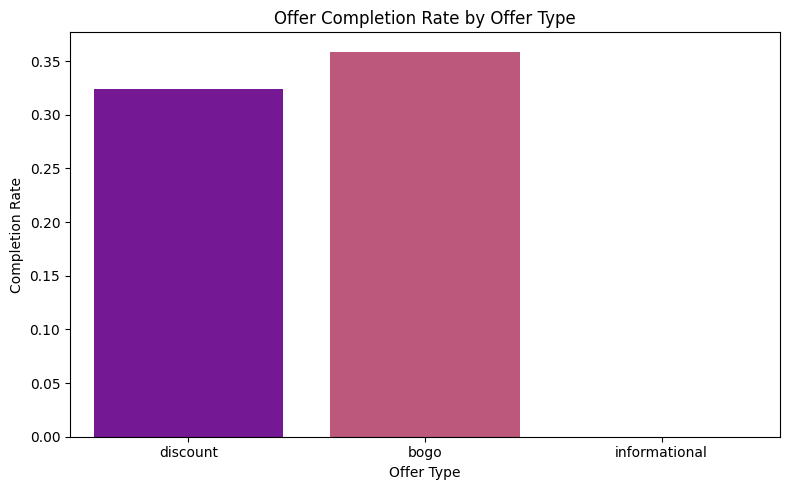

In [14]:
offers['age_bin'] = pd.cut(offers['age'], bins=[0,24,34,44,54,64,74,200],
                           labels=['<=24','25-34','35-44','45-54','55-64','65-74','75+'])

age_rates = offers.pivot_table(index='age_bin', columns='offer_type',
                               values='was_completed', aggfunc='mean')

offers['income_q'] = pd.qcut(offers['income'], 4, labels=['Q1 lowest','Q2','Q3','Q4 highest'])
income_rates = offers.pivot_table(index='income_q', columns='offer_type',
                                  values='was_completed', aggfunc='mean')

display(age_rates)
display(income_rates)

plt.figure(figsize=(8, 5))
sns.barplot(x=funnel.index, y=funnel['complete_rate'], hue=funnel.index, palette='plasma', legend=False);
plt.title('Offer Completion Rate by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Completion Rate')
plt.tight_layout()
plt.show()

This chart shows the distribution of offer events across the customer funnel by offer type. While BOGO and discount offers are received in similar volumes, BOGO offers retain more customers through the viewed and completed stages, indicating lower drop-off across the funnel.

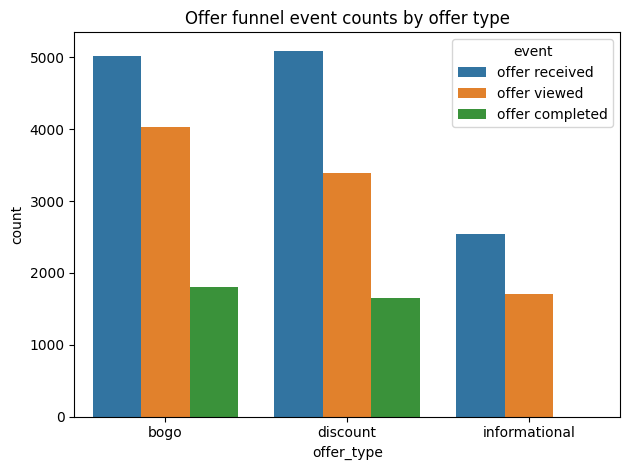

In [15]:
# Offer funnel counts
sns.countplot(data=df[df['event'].isin(['offer received','offer viewed','offer completed'])],
              x='offer_type', hue='event')
plt.title('Offer funnel event counts by offer type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


When normalized by gender, the distribution of offer types is largely consistent across all groups. This suggests that offer assignment is not strongly differentiated by gender.

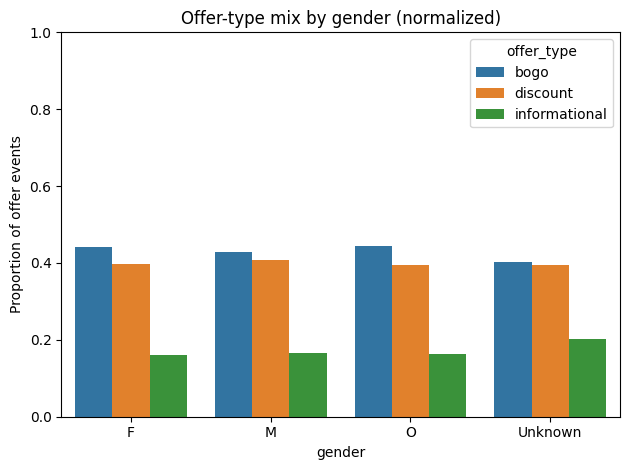

In [16]:
offer_events = df[df['event'].isin(['offer received','offer viewed','offer completed'])]

counts = (offer_events.groupby(['gender','offer_type']).size().reset_index(name='count'))
counts['percent'] = counts.groupby('gender')['count'].transform(lambda x: x / x.sum())

sns.barplot(data=counts, x='gender', y='percent', hue='offer_type')
plt.ylabel('Proportion of offer events')
plt.ylim(0,1)
plt.title('Offer-type mix by gender (normalized)')
plt.tight_layout()
plt.show()


Age exhibits a strong positive association with offer completion for BOGO and discount promotions. This pattern suggests older customers are more responsive to incentive-based offers.

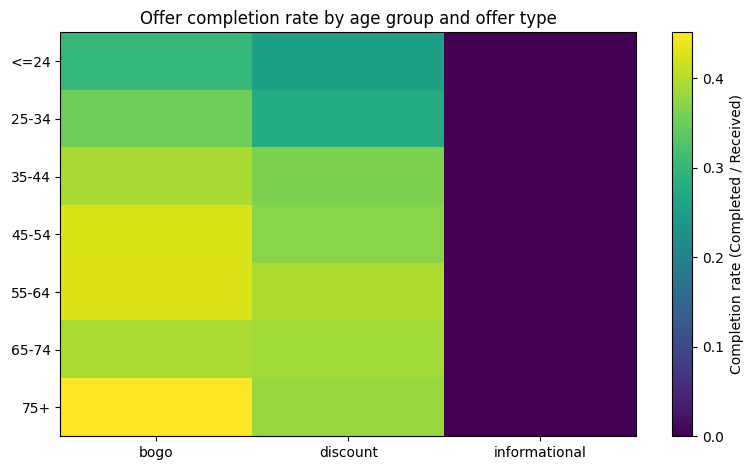

In [17]:
cols = [c for c in ['bogo','discount','informational'] if c in age_rates.columns]
data = age_rates[cols].to_numpy()

plt.figure(figsize=(8,4.8))
plt.imshow(data, aspect='auto')
plt.xticks(range(len(cols)), cols)
plt.yticks(range(len(age_rates.index)), age_rates.index.astype(str))
plt.colorbar(label='Completion rate (Completed / Received)')
plt.title('Offer completion rate by age group and offer type')
plt.tight_layout()
plt.show()


Spending during the active offer window is higher for incentive-based offers than for informational offers. BOGO promotions show the highest median spend and the widest distribution, suggesting stronger short-term purchasing activity when customers receive these incentives.

C:\Users\chaud\AppData\Local\Temp\ipykernel_13724\3209355503.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False);


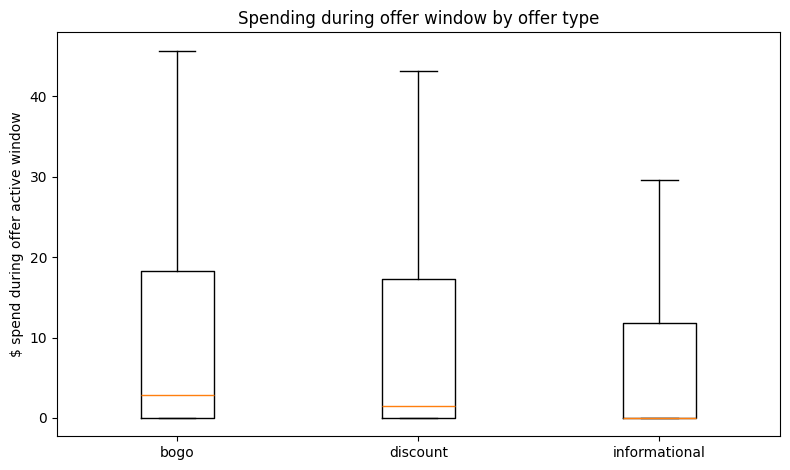

In [18]:
# Spend distribution during offer window (requires spend_in_window)
order = [c for c in ['bogo','discount','informational'] if c in offers['offer_type'].unique()]
data = [offers.loc[offers['offer_type']==ot, 'spend_in_window'].values for ot in order]

plt.figure(figsize=(8,4.8))
plt.boxplot(data, labels=order, showfliers=False);
plt.ylabel('$ spend during offer active window')
plt.title('Spending during offer window by offer type')
plt.tight_layout()
plt.show()
